In [1]:
import numpy as np
import proplot as pplt
import fitsio
import glob
import os

In [2]:
from shear_meas import meas_m_c

In [3]:
if True:
    fbase = "mdet_results/meas_exp_fluxfac1.0_"
    sep_ind = 3

all_files = glob.glob(fbase + "*")
seps = sorted(list(set([
    float(os.path.basename(fn).split("_")[sep_ind][3:])
    for fn in all_files
])))
print("seps:", seps)
data = {}
for sep in seps:
    fns = glob.glob(fbase + "sep%0.3f*" % sep)
    d = []
    for fn in fns:
        d.append(fitsio.read(fn))
    data[sep] = np.concatenate(d, axis=0)

d = np.zeros(len(seps), dtype=[
    ("m", "f8"),
    ("merr", "f8"),
    ("c", "f8"),
    ("cerr", "f8"),
    ("n", "f8"),
    ("nerr", "f8"),
    ("R", "f8"),
    ("Rerr", "f8"),
])
for i, sep in enumerate(seps):
    m, merr, c, cerr = meas_m_c(data[sep])
    d["m"][i] = m
    d["merr"][i] = merr
    d["c"][i] = c
    d["cerr"][i] = cerr
    d["n"][i] = np.mean(data[sep]["n_det"])
    d["nerr"][i] = np.std(data[sep]["n_det"])/np.sqrt(data[sep].shape[0])
    d["R"][i] = (np.mean(data[sep]["R11"]) + np.mean(data[sep]["R22"]))/2
    d["Rerr"][i] = np.sqrt(
        np.var(data[sep]["R11"]) + np.var(data[sep]["R22"])
    )/np.sqrt(2)/np.sqrt(data[sep].shape[0])
    print(sep, data[sep].shape[0], d[i])

seps: [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
1.0 4000000 (0.00055322, 8.48879387e-05, 7.5446099e-05, 0.00011276, 1.00077613, 1.21381128e-05, 1.08061787, 0.00010145)
1.25 4000000 (0.00070868, 0.00024291, 2.55335043e-05, 0.00017052, 1.14078262, 0.00016273, 0.92737456, 0.000251)
1.5 9440000 (-0.00094904, 0.000311, 0.00015066, 0.0001344, 1.80303972, 0.00012204, 0.6781783, 0.00023623)
1.75 3400000 (-0.00011199, 0.00029555, -5.58884652e-05, 0.00019309, 1.99692294, 2.7142307e-05, 0.67138829, 0.00025094)
2.0 2000000 (-0.00013881, 0.00031205, 0.00016092, 0.00017182, 1.99999725, 1.089723e-06, 0.71529065, 0.00032007)
2.25 1999000 (1.12108956e-05, 0.00030056, -0.00011123, 0.0001043, 2.00000025, 2.50125e-07, 0.8381704, 0.00033168)
2.5 2000000 (0.00054802, 0.00028602, 4.22270602e-05, 6.99019993e-05, 2.00000075, 2.01556437e-06, 0.98219027, 0.00035403)
2.75 2980000 (0.00110488, 0.0002439, -1.96209393e-05, 5.04095829e-05, 1.99999748, 2.03428734e-06, 1.09590615, 0.000315

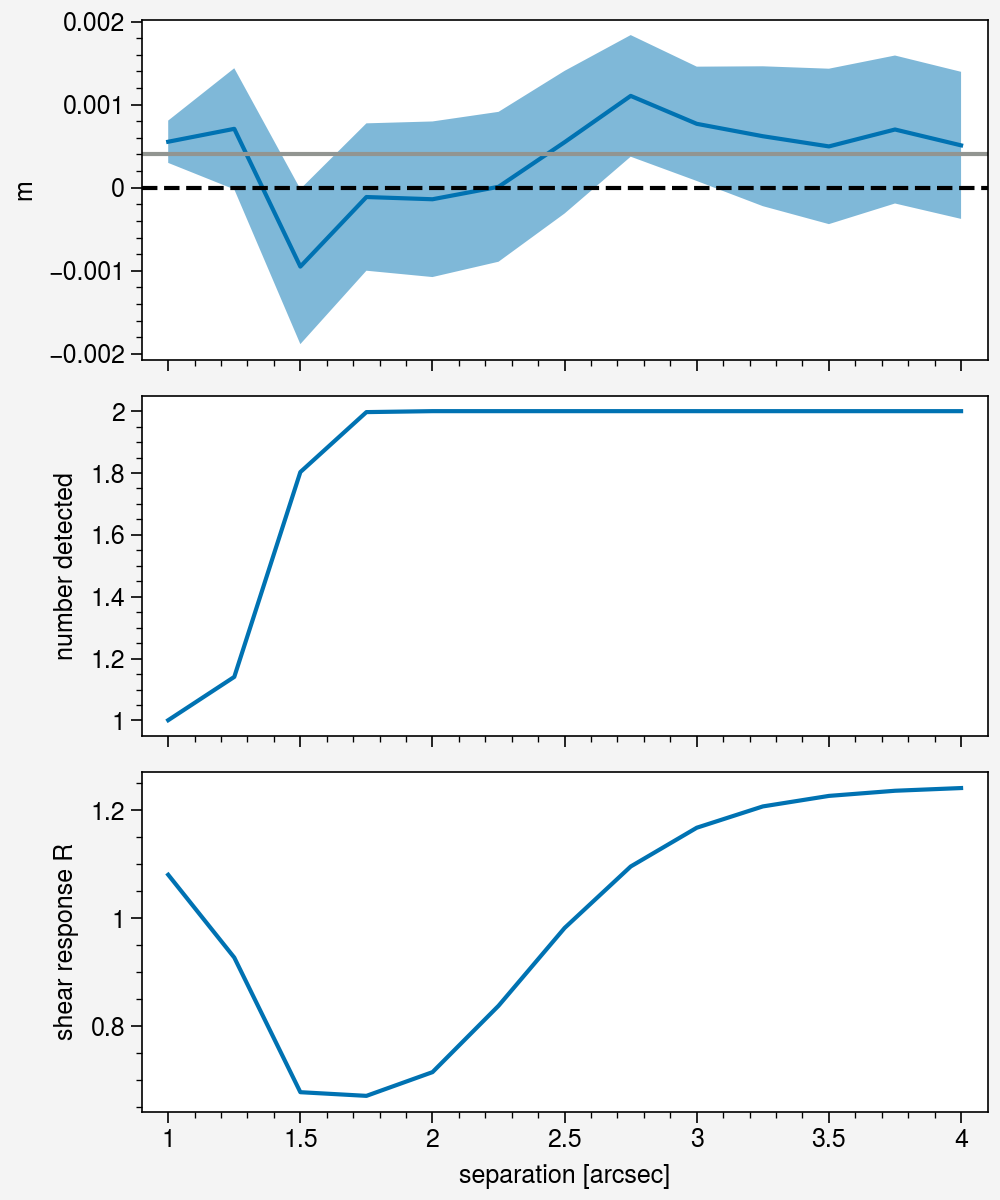

In [4]:
def _err_plot(ax, x, y, yerr):
    ax.plot(x, y)
    ax.fill_between(
        x,
        y-yerr*3,
        y+yerr*3,
        alpha=0.5,
    )

fig, axs = pplt.subplots(nrows=3, ncols=1, figsize=(5, 6), sharex=3, sharey=0)

ax = axs[0, 0]
_err_plot(ax, seps, d["m"], d["merr"])
ax.axhline(0, color='k', linestyle="dashed")
ax.axhline(0.0004, color='gray')
ax.set_ylabel("m")
# ax.set_ylim(-0.0025, 0.0025)
ax.grid(False)

ax = axs[1, 0]
_err_plot(ax, seps, d["n"], d["nerr"])
ax.set_ylabel("number detected")
ax.grid(False)

ax = axs[2, 0]
_err_plot(ax, seps, d["R"], d["Rerr"])
ax.set_ylabel("shear response R")
ax.grid(False)

ax.set_xlabel("separation [arcsec]")
delta = 0.1
ax.set_xlim(np.min(seps)-delta, np.max(seps)+delta)

fig.savefig("pair-plot.pdf")

## Plot Image of sim

In [ ]:
import numpy as np
import proplot as pplt
from measure_mdet_pairs import (
    init_wldeblend,
    get_gal_wldeblend,
    _make_obs,
    _meas_one,
    MDET_CFG,
    do_metadetect
)
import galsim

In [ ]:
wldeblend_data = init_wldeblend(survey_bands="lsst-r")

In [ ]:
rng = np.random.RandomState()
sep = 5

gal1, psf = get_gal_wldeblend(rng=rng, data=wldeblend_data)
gal2, _ = get_gal_wldeblend(rng=rng, data=wldeblend_data)
    
nse = wldeblend_data.noise
mbobs = _make_obs(
    gal1, gal2, psf, nse, rng, sep, 0.02
)

In [ ]:
mdet_res = do_metadetect(MDET_CFG, mbobs, rng)
if mdet_res is not None and mdet_res["noshear"] is not None:
    print(mdet_res["noshear"]["pgauss_s2n"])

In [ ]:
fig, axs = pplt.subplots()
axs.imshow(np.arcsinh(mbobs[0][0].image*np.sqrt(mbobs[0][0].weight)), cmap="rocket")
if mdet_res is not None and mdet_res["noshear"] is not None:
    axs.plot(mdet_res["noshear"]["sx_col"], mdet_res["noshear"]["sx_row"], 'c.')

In [ ]:
_meas_one(gal1, gal2, psf, nse, rng.randint(low=1, high=2**31), sep)